In [10]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch"""
import deepxde as dde
import numpy as np


def gen_testdata():
    data = np.load("./dataset/Burgers.npz")
    t, x, exact = data["t"], data["x"], data["usol"].T
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = exact.flatten()[:, None]
    return X, y

def chunks(l, n):
    n = max(1, n)
    return [l[i:i+n] for i in range(0, len(l), n)]
    
def pde(x, y):
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t + y * dy_x - 0.01 / np.pi * dy_xx


geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 0.99)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(
    geomtime, lambda x: -np.sin(np.pi * x[:, 0:1]), lambda _, on_initial: on_initial
)

data = dde.data.TimePDE(
    geomtime, pde, [bc, ic], num_domain=2540, num_boundary=80, num_initial=160
)
net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)

model.compile("adam", lr=1e-3)
model.train(epochs=15000)
model.compile("L-BFGS")
losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

X, y_true = gen_testdata()
y_pred = model.predict(X)
f = model.predict(X, operator=pde)
print("Mean residual:", np.mean(np.absolute(f)))
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
np.savetxt("test.dat", np.hstack((X, y_true, y_pred)))

Compiling model...
Building feed-forward neural network...
'build' took 0.148685 s

'compile' took 4.246830 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [4.37e-01, 1.45e-01, 4.67e-01]    [4.37e-01, 1.45e-01, 4.67e-01]    []  


KeyboardInterrupt: 

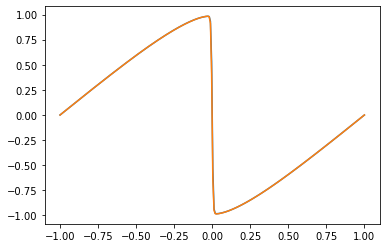

In [8]:
import matplotlib.pyplot as plt
N = 256
Xc = chunks(X, N)
y_truec = chunks(y_true, N)
y_predc = chunks(y_pred, N)

idx =50
plt.plot(Xc[idx][:,0],y_truec[idx])
plt.plot(Xc[idx][:,0],y_predc[idx])
plt.show()

In [79]:
y_pred.shape

(25600, 1)